In [65]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
import mailbox
import seaborn as sns

In [66]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [67]:
dmail = mailbox.mbox("Deliveroo.mbox")

In [68]:
merged_list = []
mails = []
restaurant = []
date = []
rtime = []
dtime = []
tip = []

In [69]:
def clean_list(dmail):
    for message in dmail:
        if message["subject"].split()[0] == 'Order':
            mails.append(message)
        else:
            continue 
    return mails

In [70]:
def clean_dtime(dtime):
    lex = dtime.split()
    lex = [lex[0].replace("m", ""), lex[1].replace("s", "")]
    return int(lex[0])*60 + int(lex[1])

In [71]:
def parse_mails(mails):
    for message in mails:
        body = str(message.get_payload())
        restaurant.append(body.partition("Restaurant:")[2].partition("\r\nRest")[0].strip())
        date.append(str.split(body.partition("at:")[2].partition("\r\nDel")[0])[0])
        rtime.append(str.split(body.partition("at:")[2].partition("\r\nDel")[0])[1])
        bad_dtime = body.partition("Time:")[2].partition("\r\n\r\n")[0].strip()
        good_dtime = clean_dtime(bad_dtime)
        dtime.append(good_dtime)
        
        tip.append(float(body.partition("Tip:")[2].partition("\r\n\r\n")[0].strip()))
        
    return [date, rtime, restaurant, dtime, tip]

In [72]:
def clean_datetime(df):
    dates = [datetime.datetime.strptime(date, "%Y-%m-%d") for date in df["Date"]]
    times = [datetime.datetime.strptime(tim, "%H:%M:%S").time() for tim in df["Time"]]
    df["Date"] = dates
    df["Time"] = times
    
    return df

In [73]:
mails = clean_list(dmail)
[date, rtime, restaurant, dtime, tip] = parse_mails(mails)
merged_list = list(zip(*[date, rtime, restaurant, dtime, tip]))

In [74]:
df = pd.DataFrame(merged_list, columns=['Date', 'Time', 'Restaurant', 'Delivery Time (s)', 'Tip'])
df = df[df["Delivery Time (s)"] < 3000]
df = clean_datetime(df)

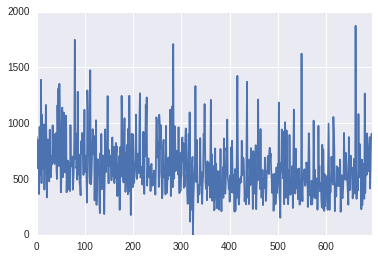

In [75]:
df["Delivery Time (s)"].plot()
m, s = divmod(df["Delivery Time (s)"].mean(), 60)
#print("{}:{}".format(m,s ))

196.0

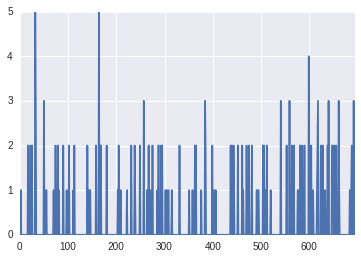

In [76]:
df["Tip"].plot()
df["Tip"].sum()

In [77]:
def roundup(number, max):
    return int(math.ceil(number / 100)) * 100

In [78]:
dateby = df.groupby(["Date"]).mean()
dtimems = []
for elem in dateby["Delivery Time (s)"]:
    m, s = divmod(elem, 60)
    dtimems.append(m + (round(s, -2) / 100))

dateby["Delivery Time (s)"] = dtimems

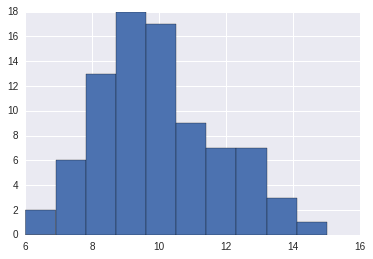

In [79]:
dateby["Delivery Time (s)"].hist()

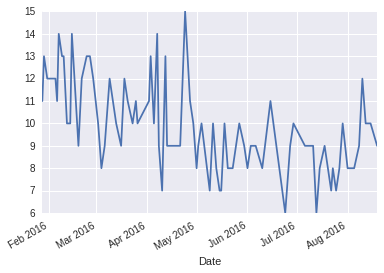

In [80]:
dateby["Delivery Time (s)"].plot()

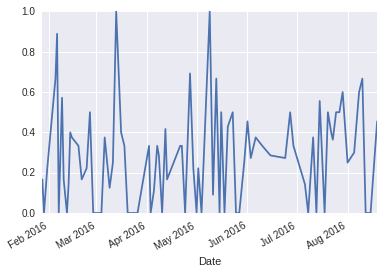

In [81]:
dateby["Tip"].plot()

/home/ruski/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


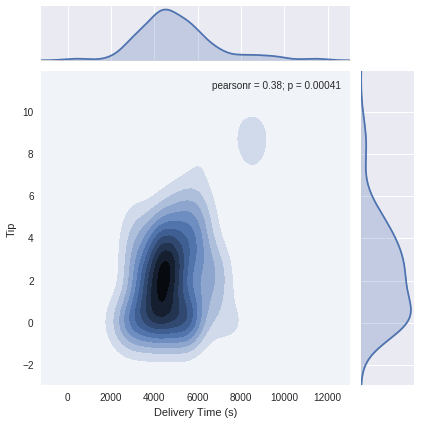

In [82]:
day_dtime_plot = df.groupby(["Date"]).sum()
day_dtime_plot
sns.jointplot(x = day_dtime_plot["Delivery Time (s)"], y = day_dtime_plot["Tip"], kind = "kde")

In [83]:
df.groupby(["Date"]).mean().max()

Delivery Time (s)    916.6
Tip                    1.0
dtype: float64

In [84]:
rest_day = df.groupby(["Restaurant"]).sum()

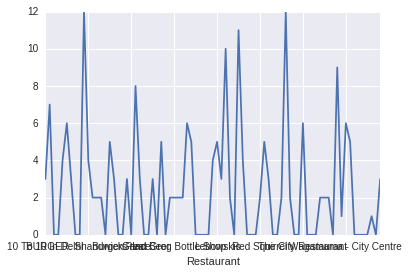

In [85]:
rest_day_mean = rest_day["Tip"]
rest_day_mean.plot()
#sns.kdeplot(rest_day_mean)

In [86]:
tip_pos = rest_day[rest_day["Tip"] != 0].count() / rest_day.count()
tip_neg = rest_day[rest_day["Tip"] == 0].count() / rest_day.count()

tip_pos

Delivery Time (s)    0.582278
Tip                  0.582278
dtype: float64

In [87]:
datetime.timedelta(minutes = 60)

datetime.timedelta(0, 3600)

In [88]:
#times = [times.replace(second = 0) for times in df["Time"]]

In [89]:
df["Time"] = [times.replace(second = 0) for times in df["Time"]]
df["Time"] = [times.replace(minute = 0) for times in df["Time"]]

In [93]:
timegrp = df.groupby(["Time"])

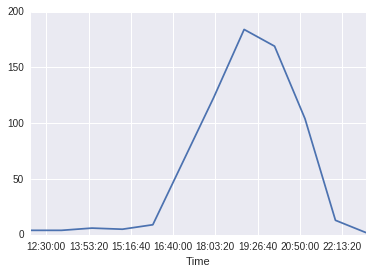

In [94]:
timegrp.count()["Restaurant"].plot()

In [95]:
timegrp.count().max()

Date                 184
Restaurant           184
Delivery Time (s)    184
Tip                  184
dtype: int64

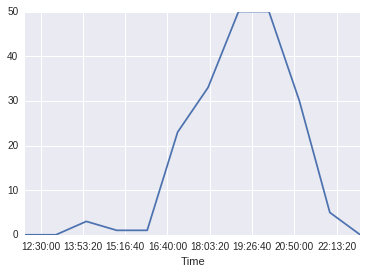

In [101]:
timegrp.sum()["Tip"].plot()